In [98]:
import torch
import numpy as np
import random
from IPython import display
from matplotlib import pyplot as plt
import torch.utils.data as Data
from PIL import Image
import os
from torch import nn
import torch.optim as optim
from torch.nn import init
import torch.nn.functional as F
import time
import pandas as pd
from sklearn.utils import shuffle
import math
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
#plt.switch_backend('agg')

In [99]:
#保存打印文件
f = open("1.1manualRNN.txt", 'a+')

In [100]:
#读取数据集，进行划分
def sliding_window(seq,window_size):
    result = []
    for i in range(len(seq)- window_size):
        result.append(seq[i: i+window_size])
    return result

data = np.load("./实验4-数据/高速公路传感器数据/PEMS04/PEMS04.npz")
#因为数据集过大，这里只取了第一个传感器的数据
data = data["data"][:,0:1,0:1]
#归一化
dmin,dmax = data.min(),data.max()
data = (data - dmin) / (dmax - dmin)
sensordata_num,sensor_num,_ = data.shape
train_set,test_set = [],[]
for  i in range(sensor_num) :
    train_seq = data[:int(sensordata_num*0.8),i,:]
    test_seq = data[int(sensordata_num*0.8):,i,:]
    train_set += sliding_window(train_seq,window_size=13)
    test_set += sliding_window(test_seq,window_size=13)
train_set,test_set= np.array(train_set).squeeze(), np.array(test_set).squeeze()
print(train_set.shape,test_set.shape)
print(train_set,test_set)

(13580, 13) (3386, 13)
[[0.09904153 0.09744409 0.11341853 ... 0.2284345  0.22683706 0.23162939]
 [0.09744409 0.11341853 0.13738019 ... 0.22683706 0.23162939 0.25878594]
 [0.11341853 0.13738019 0.16453674 ... 0.23162939 0.25878594 0.20127796]
 ...
 [0.0798722  0.09105431 0.06389776 ... 0.08626198 0.05591054 0.07667732]
 [0.09105431 0.06389776 0.07188498 ... 0.05591054 0.07667732 0.07827476]
 [0.06389776 0.07188498 0.07507987 ... 0.07667732 0.07827476 0.1086262 ]] [[0.11182109 0.13897764 0.08785942 ... 0.15335463 0.15974441 0.17891374]
 [0.13897764 0.08785942 0.07827476 ... 0.15974441 0.17891374 0.16453674]
 [0.08785942 0.07827476 0.07188498 ... 0.17891374 0.16453674 0.15974441]
 ...
 [0.24920128 0.21246006 0.17891374 ... 0.11182109 0.1086262  0.11980831]
 [0.21246006 0.17891374 0.19648562 ... 0.1086262  0.11980831 0.10543131]
 [0.17891374 0.19648562 0.1884984  ... 0.11980831 0.10543131 0.12300319]]


In [101]:
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        """
        :param input_size: 指定输入数据的维度。例如，对于简单的时间序列预测问题，每一步的输入均为一个采样值，因此input_size=1.
        :param hidden_size: 指定隐藏状态的维度。这个值并不受输入和输出控制，但会影响模型的容量。
        :param output_size: 指定输出数据的维度。此值取决于具体的预测要求。例如，对简单的时间序列预测问题，output_size=1.
        """
        super().__init__()
        self.hidden_size = hidden_size
        
        # 可学习参数的维度设置，可以类比一下全连接网络的实现。其维度取决于输入数据的维度，以及指定的隐藏状态维度。
        self.w_h = nn.Parameter(torch.rand(input_size, hidden_size))
        self.u_h = nn.Parameter(torch.rand(hidden_size, hidden_size))
        self.b_h = nn.Parameter(torch.zeros(hidden_size))
        
        self.w_y = nn.Parameter(torch.rand(hidden_size, output_size))
        self.b_y = nn.Parameter(torch.zeros(output_size))
        
        # 准备激活函数。Dropout函数可选。
        self.tanh = nn.Tanh()
        self.leaky_relu = nn.LeakyReLU()
        
        # 可选：使用性能更好的参数初始化函数
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
                
    def forward(self, x):
        """
        :param x: 输入序列。一般来说，此输入包含三个维度：batch，序列长度，以及每条数据的特征。
        """
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        # 初始化隐藏状态，一般设为全0。由于是内部新建的变量，需要同步设备位置。
        h = torch.zeros(batch_size, self.hidden_size).to(x.device)
        # RNN实际上只能一步一步处理序列。因此需要用循环迭代。
        y_list = []
        for i in range(seq_len):
            h = self.tanh(torch.matmul(x[:, i, :], self.w_h) + 
                             torch.matmul(h, self.u_h) + self.b_h)  # (batch_size, hidden_size)
            y = self.leaky_relu(torch.matmul(h, self.w_y) + self.b_y)  # (batch_size, output_size)
            y_list.append(y)
        # 一般来说，RNN的返回值为最后一步的隐藏状态，以及每一步的输出状态。
        return h, torch.stack(y_list, dim=1)

In [102]:
device = 'cpu'
model = MyRNN(input_size=1, hidden_size=32, output_size=1).to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [103]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = (y_true > 0)
    y_true = y_true[non_zero_index]
    y_pred = y_pred[non_zero_index]

    mape = np.abs((y_true - y_pred) / y_true)
    mape[np.isinf(mape)] = 0
    return np.mean(mape) * 100

In [104]:
def next_batch(data, batch_size):
    data_length = len(data)
    num_batches = math.ceil(data_length / batch_size)
    for batch_index in range(num_batches):
        start_index = batch_index * batch_size
        end_index = min((batch_index + 1) * batch_size, data_length)
        yield data[start_index:end_index]

In [105]:
#反归一化
def denormalize(x):
    return x * (dmax - dmin) + dmin

In [106]:
train_log = []
test_log = []
#开始时间
timestart = time.time()
trained_batches = 0 #记录多少个batch 
for epoch in range(100):
   
    total_1oss = 0 #记录Loss
    for batch in next_batch(shuffle(train_set), batch_size=128):
        #每一个batch的开始时间
        batchstart = time.time()
        
        batch = torch.from_numpy(batch).float().to(device)  # (batch, seq_len)
        # 使用短序列的前12个值作为历史，最后一个值作为预测值。
        x, label = batch[:, :12], batch[:, -1]
        hidden, out = model(x.unsqueeze(-1))
        prediction = out[:, -1, :].squeeze(-1)  # (batch)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #correct += (prediction == label).sum().item()
        #累加loss
        #total_1oss += loss.item( )
        trained_batches += 1
        #计算平均oss与准确率
        #train_loss = total_1oss / train_batch_num
        #train_log.append(train_loss)   
        # 每训练一定数量的batch，就在测试集上测试模型效果。
        #if trained_batches % 100 == 0:
        train_log.append(loss.detach().cpu().numpy().tolist());
        train_batch_time = (time.time() - batchstart)
        print('batch %d, train_loss %.6f,Time used %.6fs'%(trained_batches, loss,train_batch_time))
        print('batch %d, train_loss %.6f,Time used %.6fs'%(trained_batches, loss,train_batch_time),file=f)
    
        
        # 每训练一定数量的batch，就在测试集上测试模型效果。
        if trained_batches % 100 == 0:
            #每一个batch的开始时间
            batch_test_start = time.time()
            #在每个epoch上测试
            all_prediction = []
            for batch in next_batch(test_set, batch_size=128):
                batch = torch.from_numpy(batch).float().to(device)  # (batch, seq_len)
                x, label = batch[:, :12], batch[:, -1]
                hidden, out = model(x.unsqueeze(-1))
                #hidden, out = model(batch)
                prediction = out[:, -1, :].squeeze(-1)  # (batch)
                all_prediction.append(prediction.detach().cpu().numpy())

            all_prediction = np.concatenate(all_prediction)
            all_label = test_set[:, -1]
            # 没有进行反归一化操作。
            #all_prediction = denormalize(all_prediction)
            #all_label = denormalize(all_label)
            # 计算测试指标。
            rmse_score = math.sqrt(mse(all_label, all_prediction))
            mae_score = mae(all_label, all_prediction)
            mape_score = mape(all_label, all_prediction)
            test_log.append([rmse_score, mae_score, mape_score])
            test_batch_time = (time.time() - batch_test_start)
            print('***************************test_batch %d, test_rmse_loss %.6f,test_mae_loss %.6f,test_mape_loss %.6f,Time used %.6fs'%(trained_batches, rmse_score,mae_score,mape_score,test_batch_time))
            print('***************************test_batch %d, test_rmse_loss %.6f,test_mae_loss %.6f,test_mape_loss %.6f,Time used %.6fs'%(trained_batches, rmse_score,mae_score,mape_score,test_batch_time),file=f)

        #每一个epoch的结束时间
        #elapsed = (time.time() - epochstart)
    #print('epoch %d, train_loss %.6f,test_rmse_loss %.6f,test_mae_loss %.6f,test_mape_loss %.6f,Time used %.6fs'%(epoch+1, train_loss,rmse_score,mae_score,mape_score,elapsed))
    #print('epoch %d, train_loss %.6f,test_rmse_loss %.6f,test_mae_loss %.6f,test_mape_loss %.6f,Time used %.6fs'%(epoch+1, train_loss,rmse_score,mae_score,mape_score,elapsed),file=f)
    
#计算总时间
timesum = (time.time() - timestart)
print('The total time is %fs'%(timesum))
print('The total time is %fs'%(timesum),file=f)
f.close()

batch 1, train_loss 0.194326,Time used 0.009973s
batch 2, train_loss 0.228461,Time used 0.005983s
batch 3, train_loss 0.199120,Time used 0.006982s
batch 4, train_loss 0.202521,Time used 0.006981s
batch 5, train_loss 0.189436,Time used 0.006981s
batch 6, train_loss 0.203991,Time used 0.007979s
batch 7, train_loss 0.172814,Time used 0.007979s
batch 8, train_loss 0.195199,Time used 0.006981s
batch 9, train_loss 0.176031,Time used 0.006981s
batch 10, train_loss 0.161052,Time used 0.006981s
batch 11, train_loss 0.197346,Time used 0.006982s
batch 12, train_loss 0.188473,Time used 0.007979s
batch 13, train_loss 0.194746,Time used 0.007978s
batch 14, train_loss 0.212437,Time used 0.006982s
batch 15, train_loss 0.196175,Time used 0.006981s
batch 16, train_loss 0.190553,Time used 0.006981s
batch 17, train_loss 0.218149,Time used 0.007979s
batch 18, train_loss 0.211622,Time used 0.006981s
batch 19, train_loss 0.187467,Time used 0.006981s
batch 20, train_loss 0.183357,Time used 0.006981s
batch 21,

batch 173, train_loss 0.010598,Time used 0.006980s
batch 174, train_loss 0.013022,Time used 0.006981s
batch 175, train_loss 0.011640,Time used 0.006981s
batch 176, train_loss 0.009649,Time used 0.005984s
batch 177, train_loss 0.013413,Time used 0.006982s
batch 178, train_loss 0.014452,Time used 0.008975s
batch 179, train_loss 0.009544,Time used 0.006982s
batch 180, train_loss 0.012892,Time used 0.006981s
batch 181, train_loss 0.015806,Time used 0.006981s
batch 182, train_loss 0.011145,Time used 0.006981s
batch 183, train_loss 0.011282,Time used 0.006981s
batch 184, train_loss 0.011877,Time used 0.006981s
batch 185, train_loss 0.013469,Time used 0.006981s
batch 186, train_loss 0.017557,Time used 0.006981s
batch 187, train_loss 0.015469,Time used 0.006981s
batch 188, train_loss 0.009529,Time used 0.007980s
batch 189, train_loss 0.012688,Time used 0.006981s
batch 190, train_loss 0.011763,Time used 0.007978s
batch 191, train_loss 0.009741,Time used 0.006981s
batch 192, train_loss 0.010289,

batch 341, train_loss 0.008562,Time used 0.007979s
batch 342, train_loss 0.007307,Time used 0.009974s
batch 343, train_loss 0.008331,Time used 0.008975s
batch 344, train_loss 0.007686,Time used 0.007979s
batch 345, train_loss 0.011004,Time used 0.007979s
batch 346, train_loss 0.008079,Time used 0.007979s
batch 347, train_loss 0.009804,Time used 0.008976s
batch 348, train_loss 0.009824,Time used 0.008975s
batch 349, train_loss 0.008752,Time used 0.007979s
batch 350, train_loss 0.007646,Time used 0.007979s
batch 351, train_loss 0.008569,Time used 0.008976s
batch 352, train_loss 0.007374,Time used 0.008975s
batch 353, train_loss 0.009132,Time used 0.008995s
batch 354, train_loss 0.005683,Time used 0.009484s
batch 355, train_loss 0.006283,Time used 0.007977s
batch 356, train_loss 0.007730,Time used 0.007978s
batch 357, train_loss 0.007325,Time used 0.007979s
batch 358, train_loss 0.006895,Time used 0.007979s
batch 359, train_loss 0.007189,Time used 0.007978s
batch 360, train_loss 0.007819,

***************************test_batch 500, test_rmse_loss 0.076848,test_mae_loss 0.057985,test_mape_loss 20.629088,Time used 0.114693s
batch 501, train_loss 0.005825,Time used 0.009973s
batch 502, train_loss 0.005927,Time used 0.008976s
batch 503, train_loss 0.005177,Time used 0.008976s
batch 504, train_loss 0.004497,Time used 0.009973s
batch 505, train_loss 0.005175,Time used 0.008976s
batch 506, train_loss 0.005878,Time used 0.008975s
batch 507, train_loss 0.004799,Time used 0.008977s
batch 508, train_loss 0.008816,Time used 0.008976s
batch 509, train_loss 0.006168,Time used 0.008976s
batch 510, train_loss 0.004967,Time used 0.008976s
batch 511, train_loss 0.005155,Time used 0.008976s
batch 512, train_loss 0.005823,Time used 0.008976s
batch 513, train_loss 0.005942,Time used 0.008976s
batch 514, train_loss 0.005671,Time used 0.007979s
batch 515, train_loss 0.006043,Time used 0.007979s
batch 516, train_loss 0.007550,Time used 0.007979s
batch 517, train_loss 0.006445,Time used 0.007979

batch 669, train_loss 0.004609,Time used 0.008976s
batch 670, train_loss 0.006160,Time used 0.008975s
batch 671, train_loss 0.003211,Time used 0.008976s
batch 672, train_loss 0.004833,Time used 0.008976s
batch 673, train_loss 0.003754,Time used 0.008976s
batch 674, train_loss 0.005810,Time used 0.007979s
batch 675, train_loss 0.003363,Time used 0.007978s
batch 676, train_loss 0.003778,Time used 0.007979s
batch 677, train_loss 0.004778,Time used 0.007979s
batch 678, train_loss 0.003797,Time used 0.007979s
batch 679, train_loss 0.005448,Time used 0.008977s
batch 680, train_loss 0.004523,Time used 0.007978s
batch 681, train_loss 0.004267,Time used 0.007979s
batch 682, train_loss 0.005631,Time used 0.007979s
batch 683, train_loss 0.004560,Time used 0.008976s
batch 684, train_loss 0.005512,Time used 0.008976s
batch 685, train_loss 0.005129,Time used 0.008977s
batch 686, train_loss 0.004624,Time used 0.007978s
batch 687, train_loss 0.004211,Time used 0.007978s
batch 688, train_loss 0.004760,

batch 840, train_loss 0.004315,Time used 0.008976s
batch 841, train_loss 0.004121,Time used 0.008977s
batch 842, train_loss 0.003417,Time used 0.008976s
batch 843, train_loss 0.002925,Time used 0.008976s
batch 844, train_loss 0.002520,Time used 0.008976s
batch 845, train_loss 0.003472,Time used 0.007979s
batch 846, train_loss 0.003405,Time used 0.007978s
batch 847, train_loss 0.003525,Time used 0.008977s
batch 848, train_loss 0.005163,Time used 0.008975s
batch 849, train_loss 0.004303,Time used 0.008976s
batch 850, train_loss 0.003551,Time used 0.008976s
batch 851, train_loss 0.003913,Time used 0.007977s
batch 852, train_loss 0.003903,Time used 0.008976s
batch 853, train_loss 0.003823,Time used 0.008976s
batch 854, train_loss 0.003698,Time used 0.008976s
batch 855, train_loss 0.005820,Time used 0.008975s
batch 856, train_loss 0.000650,Time used 0.006981s
batch 857, train_loss 0.003222,Time used 0.008977s
batch 858, train_loss 0.004165,Time used 0.008975s
batch 859, train_loss 0.003910,

batch 1005, train_loss 0.004098,Time used 0.008976s
batch 1006, train_loss 0.005075,Time used 0.009973s
batch 1007, train_loss 0.004793,Time used 0.008976s
batch 1008, train_loss 0.003597,Time used 0.008976s
batch 1009, train_loss 0.003379,Time used 0.007978s
batch 1010, train_loss 0.004713,Time used 0.007980s
batch 1011, train_loss 0.003476,Time used 0.006982s
batch 1012, train_loss 0.003614,Time used 0.006981s
batch 1013, train_loss 0.003559,Time used 0.008975s
batch 1014, train_loss 0.004407,Time used 0.007979s
batch 1015, train_loss 0.003667,Time used 0.007979s
batch 1016, train_loss 0.003794,Time used 0.007979s
batch 1017, train_loss 0.004389,Time used 0.008976s
batch 1018, train_loss 0.005013,Time used 0.007978s
batch 1019, train_loss 0.004088,Time used 0.007978s
batch 1020, train_loss 0.003175,Time used 0.007979s
batch 1021, train_loss 0.003012,Time used 0.006982s
batch 1022, train_loss 0.003008,Time used 0.007978s
batch 1023, train_loss 0.003806,Time used 0.007980s
batch 1024, 

batch 1319, train_loss 0.003700,Time used 0.008977s
batch 1320, train_loss 0.004109,Time used 0.008977s
batch 1321, train_loss 0.004185,Time used 0.008977s
batch 1322, train_loss 0.003588,Time used 0.007978s
batch 1323, train_loss 0.003779,Time used 0.007979s
batch 1324, train_loss 0.003925,Time used 0.008976s
batch 1325, train_loss 0.004791,Time used 0.007979s
batch 1326, train_loss 0.004926,Time used 0.008976s
batch 1327, train_loss 0.002930,Time used 0.008975s
batch 1328, train_loss 0.004398,Time used 0.008976s
batch 1329, train_loss 0.002965,Time used 0.007979s
batch 1330, train_loss 0.003617,Time used 0.007978s
batch 1331, train_loss 0.004462,Time used 0.008977s
batch 1332, train_loss 0.003972,Time used 0.007978s
batch 1333, train_loss 0.003462,Time used 0.007979s
batch 1334, train_loss 0.004482,Time used 0.008976s
batch 1335, train_loss 0.003086,Time used 0.007979s
batch 1336, train_loss 0.007650,Time used 0.007979s
batch 1337, train_loss 0.003999,Time used 0.007978s
batch 1338, 

batch 1492, train_loss 0.004316,Time used 0.009974s
batch 1493, train_loss 0.002255,Time used 0.008976s
batch 1494, train_loss 0.004017,Time used 0.008977s
batch 1495, train_loss 0.003320,Time used 0.008976s
batch 1496, train_loss 0.003137,Time used 0.008976s
batch 1497, train_loss 0.003071,Time used 0.008976s
batch 1498, train_loss 0.003555,Time used 0.006981s
batch 1499, train_loss 0.005101,Time used 0.007978s
batch 1500, train_loss 0.003196,Time used 0.007978s
***************************test_batch 1500, test_rmse_loss 0.061699,test_mae_loss 0.044079,test_mape_loss 13.212676,Time used 0.110706s
batch 1501, train_loss 0.004622,Time used 0.009971s
batch 1502, train_loss 0.003495,Time used 0.008977s
batch 1503, train_loss 0.003979,Time used 0.007979s
batch 1504, train_loss 0.002119,Time used 0.007979s
batch 1505, train_loss 0.004747,Time used 0.008976s
batch 1506, train_loss 0.003959,Time used 0.008976s
batch 1507, train_loss 0.003003,Time used 0.008977s
batch 1508, train_loss 0.003371,

batch 1661, train_loss 0.003521,Time used 0.008976s
batch 1662, train_loss 0.003430,Time used 0.009974s
batch 1663, train_loss 0.003512,Time used 0.009973s
batch 1664, train_loss 0.003206,Time used 0.008976s
batch 1665, train_loss 0.004086,Time used 0.007978s
batch 1666, train_loss 0.002769,Time used 0.007980s
batch 1667, train_loss 0.003761,Time used 0.007978s
batch 1668, train_loss 0.004079,Time used 0.008975s
batch 1669, train_loss 0.003315,Time used 0.007979s
batch 1670, train_loss 0.004082,Time used 0.008976s
batch 1671, train_loss 0.004922,Time used 0.008976s
batch 1672, train_loss 0.003608,Time used 0.008976s
batch 1673, train_loss 0.003710,Time used 0.008976s
batch 1674, train_loss 0.003326,Time used 0.008977s
batch 1675, train_loss 0.003636,Time used 0.009973s
batch 1676, train_loss 0.003662,Time used 0.007979s
batch 1677, train_loss 0.003859,Time used 0.009974s
batch 1678, train_loss 0.004459,Time used 0.007979s
batch 1679, train_loss 0.005675,Time used 0.007979s
batch 1680, 

batch 1822, train_loss 0.003374,Time used 0.007979s
batch 1823, train_loss 0.003498,Time used 0.007979s
batch 1824, train_loss 0.005000,Time used 0.007979s
batch 1825, train_loss 0.003160,Time used 0.007978s
batch 1826, train_loss 0.003877,Time used 0.008977s
batch 1827, train_loss 0.003399,Time used 0.008976s
batch 1828, train_loss 0.004316,Time used 0.007978s
batch 1829, train_loss 0.003124,Time used 0.007980s
batch 1830, train_loss 0.003642,Time used 0.008975s
batch 1831, train_loss 0.004561,Time used 0.008976s
batch 1832, train_loss 0.005455,Time used 0.008976s
batch 1833, train_loss 0.002987,Time used 0.008976s
batch 1834, train_loss 0.004578,Time used 0.007979s
batch 1835, train_loss 0.003129,Time used 0.008975s
batch 1836, train_loss 0.002973,Time used 0.008976s
batch 1837, train_loss 0.004440,Time used 0.008976s
batch 1838, train_loss 0.004665,Time used 0.008976s
batch 1839, train_loss 0.004356,Time used 0.008023s
batch 1840, train_loss 0.003365,Time used 0.007979s
batch 1841, 

batch 1981, train_loss 0.003054,Time used 0.008976s
batch 1982, train_loss 0.003009,Time used 0.008976s
batch 1983, train_loss 0.004605,Time used 0.008976s
batch 1984, train_loss 0.005274,Time used 0.008976s
batch 1985, train_loss 0.003684,Time used 0.008976s
batch 1986, train_loss 0.004427,Time used 0.008976s
batch 1987, train_loss 0.004478,Time used 0.008976s
batch 1988, train_loss 0.003313,Time used 0.007979s
batch 1989, train_loss 0.003560,Time used 0.007979s
batch 1990, train_loss 0.003385,Time used 0.007978s
batch 1991, train_loss 0.003213,Time used 0.008976s
batch 1992, train_loss 0.003776,Time used 0.007979s
batch 1993, train_loss 0.003350,Time used 0.007978s
batch 1994, train_loss 0.002993,Time used 0.008975s
batch 1995, train_loss 0.003705,Time used 0.007979s
batch 1996, train_loss 0.004711,Time used 0.007978s
batch 1997, train_loss 0.004350,Time used 0.007978s
batch 1998, train_loss 0.002829,Time used 0.007977s
batch 1999, train_loss 0.003370,Time used 0.007979s
batch 2000, 

batch 2141, train_loss 0.003011,Time used 0.007979s
batch 2142, train_loss 0.002923,Time used 0.008976s
batch 2143, train_loss 0.003181,Time used 0.008976s
batch 2144, train_loss 0.003112,Time used 0.007979s
batch 2145, train_loss 0.003959,Time used 0.007979s
batch 2146, train_loss 0.003299,Time used 0.008976s
batch 2147, train_loss 0.003097,Time used 0.007978s
batch 2148, train_loss 0.004435,Time used 0.007979s
batch 2149, train_loss 0.003716,Time used 0.008975s
batch 2150, train_loss 0.003329,Time used 0.007979s
batch 2151, train_loss 0.003948,Time used 0.007979s
batch 2152, train_loss 0.004063,Time used 0.008975s
batch 2153, train_loss 0.003643,Time used 0.007978s
batch 2154, train_loss 0.003233,Time used 0.007978s
batch 2155, train_loss 0.003935,Time used 0.007979s
batch 2156, train_loss 0.002904,Time used 0.007979s
batch 2157, train_loss 0.003582,Time used 0.008975s
batch 2158, train_loss 0.003217,Time used 0.007979s
batch 2159, train_loss 0.004492,Time used 0.008977s
batch 2160, 

***************************test_batch 2300, test_rmse_loss 0.061233,test_mae_loss 0.043691,test_mape_loss 12.863174,Time used 0.112698s
batch 2301, train_loss 0.003402,Time used 0.007979s
batch 2302, train_loss 0.003378,Time used 0.007979s
batch 2303, train_loss 0.003274,Time used 0.008976s
batch 2304, train_loss 0.003324,Time used 0.007979s
batch 2305, train_loss 0.005020,Time used 0.007978s
batch 2306, train_loss 0.003730,Time used 0.007980s
batch 2307, train_loss 0.002685,Time used 0.006981s
batch 2308, train_loss 0.003709,Time used 0.007979s
batch 2309, train_loss 0.004828,Time used 0.007978s
batch 2310, train_loss 0.002796,Time used 0.007979s
batch 2311, train_loss 0.003886,Time used 0.007979s
batch 2312, train_loss 0.003155,Time used 0.008009s
batch 2313, train_loss 0.003112,Time used 0.007978s
batch 2314, train_loss 0.004345,Time used 0.006982s
batch 2315, train_loss 0.003144,Time used 0.007979s
batch 2316, train_loss 0.003757,Time used 0.007979s
batch 2317, train_loss 0.003275,

batch 2461, train_loss 0.001376,Time used 0.006981s
batch 2462, train_loss 0.004392,Time used 0.009973s
batch 2463, train_loss 0.003480,Time used 0.009974s
batch 2464, train_loss 0.002517,Time used 0.008976s
batch 2465, train_loss 0.004500,Time used 0.008976s
batch 2466, train_loss 0.002652,Time used 0.007979s
batch 2467, train_loss 0.003165,Time used 0.008976s
batch 2468, train_loss 0.002393,Time used 0.008976s
batch 2469, train_loss 0.002907,Time used 0.008976s
batch 2470, train_loss 0.002836,Time used 0.008975s
batch 2471, train_loss 0.004832,Time used 0.007979s
batch 2472, train_loss 0.004256,Time used 0.007979s
batch 2473, train_loss 0.003631,Time used 0.008976s
batch 2474, train_loss 0.004146,Time used 0.007979s
batch 2475, train_loss 0.003233,Time used 0.007978s
batch 2476, train_loss 0.003692,Time used 0.007978s
batch 2477, train_loss 0.003323,Time used 0.007979s
batch 2478, train_loss 0.003402,Time used 0.007979s
batch 2479, train_loss 0.002798,Time used 0.007978s
batch 2480, 

batch 2622, train_loss 0.004434,Time used 0.008976s
batch 2623, train_loss 0.002385,Time used 0.008976s
batch 2624, train_loss 0.003687,Time used 0.008976s
batch 2625, train_loss 0.003063,Time used 0.008976s
batch 2626, train_loss 0.003679,Time used 0.009973s
batch 2627, train_loss 0.005074,Time used 0.008977s
batch 2628, train_loss 0.003081,Time used 0.008976s
batch 2629, train_loss 0.003684,Time used 0.007978s
batch 2630, train_loss 0.003249,Time used 0.007979s
batch 2631, train_loss 0.004253,Time used 0.008976s
batch 2632, train_loss 0.003513,Time used 0.008976s
batch 2633, train_loss 0.003313,Time used 0.007978s
batch 2634, train_loss 0.003506,Time used 0.007980s
batch 2635, train_loss 0.005364,Time used 0.008977s
batch 2636, train_loss 0.003008,Time used 0.007978s
batch 2637, train_loss 0.003900,Time used 0.007979s
batch 2638, train_loss 0.003308,Time used 0.008976s
batch 2639, train_loss 0.003318,Time used 0.007979s
batch 2640, train_loss 0.004494,Time used 0.007979s
batch 2641, 

batch 2787, train_loss 0.002780,Time used 0.026481s
batch 2788, train_loss 0.003778,Time used 0.014471s
batch 2789, train_loss 0.003626,Time used 0.019947s
batch 2790, train_loss 0.004299,Time used 0.038896s
batch 2791, train_loss 0.003732,Time used 0.018498s
batch 2792, train_loss 0.002902,Time used 0.010971s
batch 2793, train_loss 0.003241,Time used 0.011968s
batch 2794, train_loss 0.002515,Time used 0.010971s
batch 2795, train_loss 0.004160,Time used 0.010971s
batch 2796, train_loss 0.005148,Time used 0.010971s
batch 2797, train_loss 0.002800,Time used 0.011968s
batch 2798, train_loss 0.003976,Time used 0.011967s
batch 2799, train_loss 0.003636,Time used 0.011968s
batch 2800, train_loss 0.004921,Time used 0.010972s
***************************test_batch 2800, test_rmse_loss 0.061036,test_mae_loss 0.043528,test_mape_loss 13.148428,Time used 0.133643s
batch 2801, train_loss 0.004746,Time used 0.008976s
batch 2802, train_loss 0.003180,Time used 0.009973s
batch 2803, train_loss 0.002981,

batch 2947, train_loss 0.003319,Time used 0.009973s
batch 2948, train_loss 0.003612,Time used 0.010971s
batch 2949, train_loss 0.003293,Time used 0.008976s
batch 2950, train_loss 0.004249,Time used 0.008977s
batch 2951, train_loss 0.002886,Time used 0.008976s
batch 2952, train_loss 0.003082,Time used 0.008977s
batch 2953, train_loss 0.003243,Time used 0.008976s
batch 2954, train_loss 0.004330,Time used 0.007978s
batch 2955, train_loss 0.002580,Time used 0.009973s
batch 2956, train_loss 0.002495,Time used 0.008976s
batch 2957, train_loss 0.002971,Time used 0.008976s
batch 2958, train_loss 0.003334,Time used 0.009027s
batch 2959, train_loss 0.002771,Time used 0.009974s
batch 2960, train_loss 0.006022,Time used 0.009973s
batch 2961, train_loss 0.002815,Time used 0.008976s
batch 2962, train_loss 0.002889,Time used 0.010971s
batch 2963, train_loss 0.004306,Time used 0.009973s
batch 2964, train_loss 0.004062,Time used 0.009974s
batch 2965, train_loss 0.003948,Time used 0.009973s
batch 2966, 

batch 3120, train_loss 0.003113,Time used 0.008976s
batch 3121, train_loss 0.004190,Time used 0.008976s
batch 3122, train_loss 0.004455,Time used 0.007979s
batch 3123, train_loss 0.004300,Time used 0.007979s
batch 3124, train_loss 0.003407,Time used 0.007978s
batch 3125, train_loss 0.002876,Time used 0.008976s
batch 3126, train_loss 0.004257,Time used 0.007978s
batch 3127, train_loss 0.003855,Time used 0.007979s
batch 3128, train_loss 0.003390,Time used 0.008977s
batch 3129, train_loss 0.003393,Time used 0.008975s
batch 3130, train_loss 0.006165,Time used 0.008976s
batch 3131, train_loss 0.002996,Time used 0.008976s
batch 3132, train_loss 0.002197,Time used 0.008975s
batch 3133, train_loss 0.003451,Time used 0.008976s
batch 3134, train_loss 0.002528,Time used 0.008977s
batch 3135, train_loss 0.003325,Time used 0.008976s
batch 3136, train_loss 0.003011,Time used 0.007979s
batch 3137, train_loss 0.003218,Time used 0.008976s
batch 3138, train_loss 0.005155,Time used 0.007979s
batch 3139, 

batch 3279, train_loss 0.004502,Time used 0.008976s
batch 3280, train_loss 0.003832,Time used 0.008976s
batch 3281, train_loss 0.003029,Time used 0.008975s
batch 3282, train_loss 0.003292,Time used 0.007979s
batch 3283, train_loss 0.003045,Time used 0.007979s
batch 3284, train_loss 0.002622,Time used 0.008975s
batch 3285, train_loss 0.004198,Time used 0.008976s
batch 3286, train_loss 0.003931,Time used 0.008976s
batch 3287, train_loss 0.003901,Time used 0.008977s
batch 3288, train_loss 0.002797,Time used 0.009974s
batch 3289, train_loss 0.004121,Time used 0.008976s
batch 3290, train_loss 0.003496,Time used 0.008976s
batch 3291, train_loss 0.004662,Time used 0.007979s
batch 3292, train_loss 0.004158,Time used 0.008976s
batch 3293, train_loss 0.004018,Time used 0.009973s
batch 3294, train_loss 0.005653,Time used 0.008976s
batch 3295, train_loss 0.004139,Time used 0.008976s
batch 3296, train_loss 0.003664,Time used 0.008976s
batch 3297, train_loss 0.003572,Time used 0.008976s
batch 3298, 

batch 3445, train_loss 0.003455,Time used 0.009974s
batch 3446, train_loss 0.003202,Time used 0.010971s
batch 3447, train_loss 0.004058,Time used 0.008976s
batch 3448, train_loss 0.003174,Time used 0.009973s
batch 3449, train_loss 0.002971,Time used 0.009973s
batch 3450, train_loss 0.003890,Time used 0.009974s
batch 3451, train_loss 0.003409,Time used 0.008975s
batch 3452, train_loss 0.002640,Time used 0.008977s
batch 3453, train_loss 0.004802,Time used 0.009973s
batch 3454, train_loss 0.002711,Time used 0.009974s
batch 3455, train_loss 0.003549,Time used 0.008975s
batch 3456, train_loss 0.003573,Time used 0.008976s
batch 3457, train_loss 0.002644,Time used 0.008976s
batch 3458, train_loss 0.004153,Time used 0.008976s
batch 3459, train_loss 0.002367,Time used 0.008976s
batch 3460, train_loss 0.004485,Time used 0.008976s
batch 3461, train_loss 0.004037,Time used 0.008977s
batch 3462, train_loss 0.003374,Time used 0.008976s
batch 3463, train_loss 0.006708,Time used 0.009973s
batch 3464, 

***************************test_batch 3600, test_rmse_loss 0.061094,test_mae_loss 0.043598,test_mape_loss 12.788255,Time used 0.115690s
batch 3601, train_loss 0.002820,Time used 0.008976s
batch 3602, train_loss 0.004030,Time used 0.009974s
batch 3603, train_loss 0.004671,Time used 0.009974s
batch 3604, train_loss 0.004134,Time used 0.008976s
batch 3605, train_loss 0.003631,Time used 0.008976s
batch 3606, train_loss 0.003245,Time used 0.008977s
batch 3607, train_loss 0.004341,Time used 0.009973s
batch 3608, train_loss 0.003407,Time used 0.008975s
batch 3609, train_loss 0.003090,Time used 0.008976s
batch 3610, train_loss 0.003553,Time used 0.008976s
batch 3611, train_loss 0.003121,Time used 0.009974s
batch 3612, train_loss 0.003750,Time used 0.008976s
batch 3613, train_loss 0.002864,Time used 0.008976s
batch 3614, train_loss 0.002767,Time used 0.009974s
batch 3615, train_loss 0.003326,Time used 0.008976s
batch 3616, train_loss 0.003075,Time used 0.009973s
batch 3617, train_loss 0.003286,

batch 3765, train_loss 0.004159,Time used 0.008977s
batch 3766, train_loss 0.004601,Time used 0.008977s
batch 3767, train_loss 0.002309,Time used 0.008975s
batch 3768, train_loss 0.004420,Time used 0.008976s
batch 3769, train_loss 0.003497,Time used 0.008977s
batch 3770, train_loss 0.003112,Time used 0.008976s
batch 3771, train_loss 0.003624,Time used 0.007978s
batch 3772, train_loss 0.003183,Time used 0.007979s
batch 3773, train_loss 0.003416,Time used 0.007979s
batch 3774, train_loss 0.004788,Time used 0.007979s
batch 3775, train_loss 0.004206,Time used 0.007978s
batch 3776, train_loss 0.003205,Time used 0.007978s
batch 3777, train_loss 0.003911,Time used 0.010970s
batch 3778, train_loss 0.003354,Time used 0.007980s
batch 3779, train_loss 0.005031,Time used 0.008975s
batch 3780, train_loss 0.003494,Time used 0.008976s
batch 3781, train_loss 0.003752,Time used 0.008976s
batch 3782, train_loss 0.003884,Time used 0.008976s
batch 3783, train_loss 0.003811,Time used 0.008976s
batch 3784, 

batch 3927, train_loss 0.002975,Time used 0.007980s
batch 3928, train_loss 0.004412,Time used 0.008976s
batch 3929, train_loss 0.006211,Time used 0.007978s
batch 3930, train_loss 0.003585,Time used 0.008976s
batch 3931, train_loss 0.003601,Time used 0.008976s
batch 3932, train_loss 0.003963,Time used 0.008975s
batch 3933, train_loss 0.003505,Time used 0.008976s
batch 3934, train_loss 0.003927,Time used 0.008976s
batch 3935, train_loss 0.003262,Time used 0.007978s
batch 3936, train_loss 0.003386,Time used 0.008975s
batch 3937, train_loss 0.003373,Time used 0.008977s
batch 3938, train_loss 0.003068,Time used 0.007979s
batch 3939, train_loss 0.004292,Time used 0.007979s
batch 3940, train_loss 0.003554,Time used 0.007978s
batch 3941, train_loss 0.003479,Time used 0.008976s
batch 3942, train_loss 0.004651,Time used 0.007979s
batch 3943, train_loss 0.003430,Time used 0.008976s
batch 3944, train_loss 0.003918,Time used 0.008976s
batch 3945, train_loss 0.003027,Time used 0.008976s
batch 3946, 

batch 4083, train_loss 0.002806,Time used 0.008976s
batch 4084, train_loss 0.003553,Time used 0.008976s
batch 4085, train_loss 0.004439,Time used 0.008977s
batch 4086, train_loss 0.003364,Time used 0.008976s
batch 4087, train_loss 0.002536,Time used 0.008976s
batch 4088, train_loss 0.004081,Time used 0.009975s
batch 4089, train_loss 0.003744,Time used 0.010970s
batch 4090, train_loss 0.002656,Time used 0.010971s
batch 4091, train_loss 0.003789,Time used 0.009973s
batch 4092, train_loss 0.003653,Time used 0.009973s
batch 4093, train_loss 0.003190,Time used 0.008977s
batch 4094, train_loss 0.004184,Time used 0.008975s
batch 4095, train_loss 0.003246,Time used 0.008976s
batch 4096, train_loss 0.005825,Time used 0.007978s
batch 4097, train_loss 0.004428,Time used 0.008975s
batch 4098, train_loss 0.002147,Time used 0.008976s
batch 4099, train_loss 0.003406,Time used 0.008976s
batch 4100, train_loss 0.002959,Time used 0.008975s
***************************test_batch 4100, test_rmse_loss 0.060

batch 4240, train_loss 0.005422,Time used 0.007978s
batch 4241, train_loss 0.004624,Time used 0.008976s
batch 4242, train_loss 0.003526,Time used 0.007979s
batch 4243, train_loss 0.003965,Time used 0.007979s
batch 4244, train_loss 0.002825,Time used 0.008976s
batch 4245, train_loss 0.004180,Time used 0.010970s
batch 4246, train_loss 0.002537,Time used 0.007979s
batch 4247, train_loss 0.004838,Time used 0.007979s
batch 4248, train_loss 0.003747,Time used 0.008976s
batch 4249, train_loss 0.003925,Time used 0.007979s
batch 4250, train_loss 0.004212,Time used 0.008977s
batch 4251, train_loss 0.003991,Time used 0.008977s
batch 4252, train_loss 0.003305,Time used 0.008975s
batch 4253, train_loss 0.003473,Time used 0.007978s
batch 4254, train_loss 0.003192,Time used 0.007979s
batch 4255, train_loss 0.003536,Time used 0.007978s
batch 4256, train_loss 0.002936,Time used 0.007978s
batch 4257, train_loss 0.003982,Time used 0.008976s
batch 4258, train_loss 0.002478,Time used 0.006983s
batch 4259, 

***************************test_batch 4400, test_rmse_loss 0.060971,test_mae_loss 0.043473,test_mape_loss 12.775923,Time used 0.113758s
batch 4401, train_loss 0.003269,Time used 0.007978s
batch 4402, train_loss 0.005564,Time used 0.007978s
batch 4403, train_loss 0.003551,Time used 0.008976s
batch 4404, train_loss 0.004923,Time used 0.008976s
batch 4405, train_loss 0.004493,Time used 0.008976s
batch 4406, train_loss 0.002773,Time used 0.008976s
batch 4407, train_loss 0.003704,Time used 0.009973s
batch 4408, train_loss 0.002800,Time used 0.009973s
batch 4409, train_loss 0.002692,Time used 0.008976s
batch 4410, train_loss 0.003755,Time used 0.008976s
batch 4411, train_loss 0.004147,Time used 0.008976s
batch 4412, train_loss 0.002278,Time used 0.009973s
batch 4413, train_loss 0.003417,Time used 0.008977s
batch 4414, train_loss 0.003312,Time used 0.007979s
batch 4415, train_loss 0.004467,Time used 0.007979s
batch 4416, train_loss 0.002933,Time used 0.007979s
batch 4417, train_loss 0.003644,

batch 4564, train_loss 0.003252,Time used 0.008976s
batch 4565, train_loss 0.003270,Time used 0.009974s
batch 4566, train_loss 0.003553,Time used 0.008976s
batch 4567, train_loss 0.003330,Time used 0.008976s
batch 4568, train_loss 0.003284,Time used 0.009974s
batch 4569, train_loss 0.002667,Time used 0.008976s
batch 4570, train_loss 0.003975,Time used 0.008976s
batch 4571, train_loss 0.003694,Time used 0.008976s
batch 4572, train_loss 0.003829,Time used 0.007978s
batch 4573, train_loss 0.003495,Time used 0.008976s
batch 4574, train_loss 0.005158,Time used 0.007978s
batch 4575, train_loss 0.002976,Time used 0.008977s
batch 4576, train_loss 0.003127,Time used 0.008976s
batch 4577, train_loss 0.004192,Time used 0.008976s
batch 4578, train_loss 0.006831,Time used 0.007979s
batch 4579, train_loss 0.003493,Time used 0.007979s
batch 4580, train_loss 0.004096,Time used 0.008976s
batch 4581, train_loss 0.004234,Time used 0.007979s
batch 4582, train_loss 0.002335,Time used 0.007979s
batch 4583, 

batch 4729, train_loss 0.002577,Time used 0.007978s
batch 4730, train_loss 0.003587,Time used 0.008976s
batch 4731, train_loss 0.003294,Time used 0.008976s
batch 4732, train_loss 0.003561,Time used 0.008976s
batch 4733, train_loss 0.002583,Time used 0.007978s
batch 4734, train_loss 0.004463,Time used 0.007979s
batch 4735, train_loss 0.004833,Time used 0.007979s
batch 4736, train_loss 0.003285,Time used 0.008977s
batch 4737, train_loss 0.004040,Time used 0.007978s
batch 4738, train_loss 0.004839,Time used 0.007980s
batch 4739, train_loss 0.003788,Time used 0.007978s
batch 4740, train_loss 0.003204,Time used 0.007979s
batch 4741, train_loss 0.003440,Time used 0.008976s
batch 4742, train_loss 0.002972,Time used 0.008976s
batch 4743, train_loss 0.003212,Time used 0.007978s
batch 4744, train_loss 0.003142,Time used 0.007978s
batch 4745, train_loss 0.003709,Time used 0.007979s
batch 4746, train_loss 0.004528,Time used 0.007979s
batch 4747, train_loss 0.002803,Time used 0.007979s
batch 4748, 

batch 4886, train_loss 0.003083,Time used 0.006982s
batch 4887, train_loss 0.004523,Time used 0.008976s
batch 4888, train_loss 0.003597,Time used 0.008976s
batch 4889, train_loss 0.003417,Time used 0.008976s
batch 4890, train_loss 0.003765,Time used 0.008976s
batch 4891, train_loss 0.002635,Time used 0.007978s
batch 4892, train_loss 0.003534,Time used 0.007980s
batch 4893, train_loss 0.003519,Time used 0.008976s
batch 4894, train_loss 0.002811,Time used 0.008976s
batch 4895, train_loss 0.003153,Time used 0.007978s
batch 4896, train_loss 0.005890,Time used 0.009973s
batch 4897, train_loss 0.003330,Time used 0.008976s
batch 4898, train_loss 0.002835,Time used 0.008976s
batch 4899, train_loss 0.003733,Time used 0.009973s
batch 4900, train_loss 0.002848,Time used 0.008976s
***************************test_batch 4900, test_rmse_loss 0.060905,test_mae_loss 0.043429,test_mape_loss 12.774273,Time used 0.110704s
batch 4901, train_loss 0.004549,Time used 0.008977s
batch 4902, train_loss 0.004094,

batch 5052, train_loss 0.004716,Time used 0.008976s
batch 5053, train_loss 0.004085,Time used 0.008976s
batch 5054, train_loss 0.003981,Time used 0.007979s
batch 5055, train_loss 0.005477,Time used 0.008976s
batch 5056, train_loss 0.003312,Time used 0.007979s
batch 5057, train_loss 0.002906,Time used 0.007980s
batch 5058, train_loss 0.003827,Time used 0.008975s
batch 5059, train_loss 0.003719,Time used 0.007979s
batch 5060, train_loss 0.003023,Time used 0.008976s
batch 5061, train_loss 0.004474,Time used 0.008976s
batch 5062, train_loss 0.002799,Time used 0.007979s
batch 5063, train_loss 0.002842,Time used 0.008976s
batch 5064, train_loss 0.003474,Time used 0.007978s
batch 5065, train_loss 0.004028,Time used 0.008976s
batch 5066, train_loss 0.004030,Time used 0.008976s
batch 5067, train_loss 0.003959,Time used 0.008976s
batch 5068, train_loss 0.003761,Time used 0.008975s
batch 5069, train_loss 0.003350,Time used 0.008977s
batch 5070, train_loss 0.003434,Time used 0.008975s
batch 5071, 

batch 5220, train_loss 0.004379,Time used 0.008976s
batch 5221, train_loss 0.003655,Time used 0.009974s
batch 5222, train_loss 0.003678,Time used 0.007979s
batch 5223, train_loss 0.003509,Time used 0.007978s
batch 5224, train_loss 0.003315,Time used 0.007979s
batch 5225, train_loss 0.003090,Time used 0.008976s
batch 5226, train_loss 0.003864,Time used 0.008976s
batch 5227, train_loss 0.004218,Time used 0.008976s
batch 5228, train_loss 0.002589,Time used 0.008976s
batch 5229, train_loss 0.003774,Time used 0.008976s
batch 5230, train_loss 0.003910,Time used 0.009973s
batch 5231, train_loss 0.004392,Time used 0.008976s
batch 5232, train_loss 0.004541,Time used 0.008975s
batch 5233, train_loss 0.002781,Time used 0.008976s
batch 5234, train_loss 0.003729,Time used 0.008976s
batch 5235, train_loss 0.003620,Time used 0.008975s
batch 5236, train_loss 0.003791,Time used 0.007978s
batch 5237, train_loss 0.002777,Time used 0.007978s
batch 5238, train_loss 0.002482,Time used 0.007978s
batch 5239, 

batch 5383, train_loss 0.003371,Time used 0.008976s
batch 5384, train_loss 0.003619,Time used 0.008976s
batch 5385, train_loss 0.003256,Time used 0.008977s
batch 5386, train_loss 0.003193,Time used 0.008976s
batch 5387, train_loss 0.003787,Time used 0.009973s
batch 5388, train_loss 0.004047,Time used 0.009973s
batch 5389, train_loss 0.004439,Time used 0.009974s
batch 5390, train_loss 0.003936,Time used 0.009974s
batch 5391, train_loss 0.004078,Time used 0.008975s
batch 5392, train_loss 0.002989,Time used 0.007978s
batch 5393, train_loss 0.003183,Time used 0.007978s
batch 5394, train_loss 0.004928,Time used 0.009973s
batch 5395, train_loss 0.004064,Time used 0.023936s
batch 5396, train_loss 0.003872,Time used 0.010971s
batch 5397, train_loss 0.003028,Time used 0.011968s
batch 5398, train_loss 0.004009,Time used 0.023498s
batch 5399, train_loss 0.003888,Time used 0.016467s
batch 5400, train_loss 0.002864,Time used 0.015958s
***************************test_batch 5400, test_rmse_loss 0.060

***************************test_batch 5700, test_rmse_loss 0.061182,test_mae_loss 0.043685,test_mape_loss 12.739527,Time used 0.110704s
batch 5701, train_loss 0.003784,Time used 0.007979s
batch 5702, train_loss 0.004745,Time used 0.007979s
batch 5703, train_loss 0.003989,Time used 0.008976s
batch 5704, train_loss 0.004078,Time used 0.007979s
batch 5705, train_loss 0.003262,Time used 0.007978s
batch 5706, train_loss 0.003833,Time used 0.007979s
batch 5707, train_loss 0.005610,Time used 0.008976s
batch 5708, train_loss 0.002704,Time used 0.007979s
batch 5709, train_loss 0.003372,Time used 0.007979s
batch 5710, train_loss 0.002210,Time used 0.008977s
batch 5711, train_loss 0.002855,Time used 0.007978s
batch 5712, train_loss 0.005676,Time used 0.007979s
batch 5713, train_loss 0.004456,Time used 0.007980s
batch 5714, train_loss 0.003575,Time used 0.007979s
batch 5715, train_loss 0.003787,Time used 0.007979s
batch 5716, train_loss 0.003772,Time used 0.007978s
batch 5717, train_loss 0.003804,

batch 5863, train_loss 0.007307,Time used 0.007978s
batch 5864, train_loss 0.002745,Time used 0.008976s
batch 5865, train_loss 0.002503,Time used 0.007978s
batch 5866, train_loss 0.004206,Time used 0.007980s
batch 5867, train_loss 0.004427,Time used 0.006981s
batch 5868, train_loss 0.004658,Time used 0.007979s
batch 5869, train_loss 0.003445,Time used 0.008976s
batch 5870, train_loss 0.003791,Time used 0.007979s
batch 5871, train_loss 0.004097,Time used 0.007978s
batch 5872, train_loss 0.003499,Time used 0.007979s
batch 5873, train_loss 0.003350,Time used 0.007979s
batch 5874, train_loss 0.003220,Time used 0.007979s
batch 5875, train_loss 0.002788,Time used 0.007978s
batch 5876, train_loss 0.003431,Time used 0.007978s
batch 5877, train_loss 0.003202,Time used 0.007978s
batch 5878, train_loss 0.003685,Time used 0.008977s
batch 5879, train_loss 0.003894,Time used 0.008976s
batch 5880, train_loss 0.003571,Time used 0.008975s
batch 5881, train_loss 0.003409,Time used 0.008977s
batch 5882, 

batch 6027, train_loss 0.004437,Time used 0.008976s
batch 6028, train_loss 0.003555,Time used 0.008976s
batch 6029, train_loss 0.005888,Time used 0.007978s
batch 6030, train_loss 0.003423,Time used 0.006982s
batch 6031, train_loss 0.004012,Time used 0.008976s
batch 6032, train_loss 0.005031,Time used 0.007979s
batch 6033, train_loss 0.002755,Time used 0.008976s
batch 6034, train_loss 0.003607,Time used 0.007978s
batch 6035, train_loss 0.003264,Time used 0.007979s
batch 6036, train_loss 0.004093,Time used 0.008976s
batch 6037, train_loss 0.004582,Time used 0.008976s
batch 6038, train_loss 0.004312,Time used 0.008977s
batch 6039, train_loss 0.004137,Time used 0.008975s
batch 6040, train_loss 0.002191,Time used 0.007979s
batch 6041, train_loss 0.002670,Time used 0.007978s
batch 6042, train_loss 0.002882,Time used 0.008975s
batch 6043, train_loss 0.003422,Time used 0.008977s
batch 6044, train_loss 0.004048,Time used 0.007977s
batch 6045, train_loss 0.003389,Time used 0.007979s
batch 6046, 

batch 6182, train_loss 0.002125,Time used 0.007979s
batch 6183, train_loss 0.003749,Time used 0.008977s
batch 6184, train_loss 0.002680,Time used 0.008975s
batch 6185, train_loss 0.004170,Time used 0.008976s
batch 6186, train_loss 0.003174,Time used 0.007979s
batch 6187, train_loss 0.003632,Time used 0.008976s
batch 6188, train_loss 0.003930,Time used 0.008976s
batch 6189, train_loss 0.003836,Time used 0.008976s
batch 6190, train_loss 0.002840,Time used 0.007979s
batch 6191, train_loss 0.003655,Time used 0.008976s
batch 6192, train_loss 0.003097,Time used 0.008976s
batch 6193, train_loss 0.002763,Time used 0.008975s
batch 6194, train_loss 0.004529,Time used 0.008976s
batch 6195, train_loss 0.003974,Time used 0.008976s
batch 6196, train_loss 0.002760,Time used 0.015958s
batch 6197, train_loss 0.004247,Time used 0.008976s
batch 6198, train_loss 0.003367,Time used 0.008977s
batch 6199, train_loss 0.003778,Time used 0.008977s
batch 6200, train_loss 0.003296,Time used 0.008976s
************

batch 6342, train_loss 0.002351,Time used 0.009973s
batch 6343, train_loss 0.003599,Time used 0.008976s
batch 6344, train_loss 0.003697,Time used 0.008978s
batch 6345, train_loss 0.002975,Time used 0.008976s
batch 6346, train_loss 0.004043,Time used 0.009972s
batch 6347, train_loss 0.003125,Time used 0.008975s
batch 6348, train_loss 0.003058,Time used 0.009973s
batch 6349, train_loss 0.003472,Time used 0.009973s
batch 6350, train_loss 0.002933,Time used 0.009974s
batch 6351, train_loss 0.003166,Time used 0.011969s
batch 6352, train_loss 0.003312,Time used 0.009972s
batch 6353, train_loss 0.003382,Time used 0.009974s
batch 6354, train_loss 0.003367,Time used 0.009974s
batch 6355, train_loss 0.002616,Time used 0.009972s
batch 6356, train_loss 0.003515,Time used 0.008977s
batch 6357, train_loss 0.003982,Time used 0.008976s
batch 6358, train_loss 0.004059,Time used 0.008976s
batch 6359, train_loss 0.004510,Time used 0.008976s
batch 6360, train_loss 0.004560,Time used 0.009973s
batch 6361, 

***************************test_batch 6500, test_rmse_loss 0.060925,test_mae_loss 0.043425,test_mape_loss 12.751349,Time used 0.110705s
batch 6501, train_loss 0.004131,Time used 0.008976s
batch 6502, train_loss 0.003692,Time used 0.008976s
batch 6503, train_loss 0.003700,Time used 0.007979s
batch 6504, train_loss 0.002621,Time used 0.007979s
batch 6505, train_loss 0.003899,Time used 0.007978s
batch 6506, train_loss 0.004158,Time used 0.007978s
batch 6507, train_loss 0.003501,Time used 0.007978s
batch 6508, train_loss 0.002731,Time used 0.007979s
batch 6509, train_loss 0.003062,Time used 0.006981s
batch 6510, train_loss 0.002933,Time used 0.007979s
batch 6511, train_loss 0.002606,Time used 0.007979s
batch 6512, train_loss 0.003737,Time used 0.007979s
batch 6513, train_loss 0.003639,Time used 0.007979s
batch 6514, train_loss 0.002564,Time used 0.007979s
batch 6515, train_loss 0.003317,Time used 0.007979s
batch 6516, train_loss 0.005191,Time used 0.008975s
batch 6517, train_loss 0.004306,

batch 6664, train_loss 0.004008,Time used 0.007978s
batch 6665, train_loss 0.003047,Time used 0.009974s
batch 6666, train_loss 0.003778,Time used 0.008975s
batch 6667, train_loss 0.003550,Time used 0.008976s
batch 6668, train_loss 0.003361,Time used 0.011968s
batch 6669, train_loss 0.004156,Time used 0.009973s
batch 6670, train_loss 0.003433,Time used 0.007978s
batch 6671, train_loss 0.002703,Time used 0.007978s
batch 6672, train_loss 0.003122,Time used 0.007979s
batch 6673, train_loss 0.003710,Time used 0.006982s
batch 6674, train_loss 0.003028,Time used 0.006982s
batch 6675, train_loss 0.003889,Time used 0.007979s
batch 6676, train_loss 0.002859,Time used 0.008975s
batch 6677, train_loss 0.003475,Time used 0.006982s
batch 6678, train_loss 0.003278,Time used 0.008976s
batch 6679, train_loss 0.003144,Time used 0.008976s
batch 6680, train_loss 0.003957,Time used 0.007979s
batch 6681, train_loss 0.003240,Time used 0.007979s
batch 6682, train_loss 0.003270,Time used 0.006981s
batch 6683, 

batch 6826, train_loss 0.003387,Time used 0.008976s
batch 6827, train_loss 0.004657,Time used 0.008976s
batch 6828, train_loss 0.003495,Time used 0.007952s
batch 6829, train_loss 0.003513,Time used 0.007979s
batch 6830, train_loss 0.004897,Time used 0.007978s
batch 6831, train_loss 0.003354,Time used 0.008976s
batch 6832, train_loss 0.004163,Time used 0.008976s
batch 6833, train_loss 0.004162,Time used 0.008976s
batch 6834, train_loss 0.003755,Time used 0.008976s
batch 6835, train_loss 0.005320,Time used 0.007979s
batch 6836, train_loss 0.003290,Time used 0.007979s
batch 6837, train_loss 0.003877,Time used 0.008976s
batch 6838, train_loss 0.003432,Time used 0.007979s
batch 6839, train_loss 0.003291,Time used 0.007979s
batch 6840, train_loss 0.003886,Time used 0.008976s
batch 6841, train_loss 0.004184,Time used 0.008976s
batch 6842, train_loss 0.003476,Time used 0.007979s
batch 6843, train_loss 0.003413,Time used 0.009974s
batch 6844, train_loss 0.003526,Time used 0.007979s
batch 6845, 

batch 6999, train_loss 0.003438,Time used 0.008976s
batch 7000, train_loss 0.003668,Time used 0.007978s
***************************test_batch 7000, test_rmse_loss 0.061078,test_mae_loss 0.043541,test_mape_loss 12.721672,Time used 0.102726s
batch 7001, train_loss 0.003274,Time used 0.008976s
batch 7002, train_loss 0.004280,Time used 0.008976s
batch 7003, train_loss 0.003810,Time used 0.008975s
batch 7004, train_loss 0.006212,Time used 0.008977s
batch 7005, train_loss 0.003139,Time used 0.008977s
batch 7006, train_loss 0.003398,Time used 0.008975s
batch 7007, train_loss 0.004580,Time used 0.008976s
batch 7008, train_loss 0.003955,Time used 0.008976s
batch 7009, train_loss 0.002756,Time used 0.009974s
batch 7010, train_loss 0.002648,Time used 0.007978s
batch 7011, train_loss 0.002967,Time used 0.008976s
batch 7012, train_loss 0.003882,Time used 0.008976s
batch 7013, train_loss 0.003610,Time used 0.007978s
batch 7014, train_loss 0.004437,Time used 0.008976s
batch 7015, train_loss 0.004540,

batch 7162, train_loss 0.002891,Time used 0.008976s
batch 7163, train_loss 0.003296,Time used 0.008976s
batch 7164, train_loss 0.003950,Time used 0.009973s
batch 7165, train_loss 0.003339,Time used 0.008976s
batch 7166, train_loss 0.004188,Time used 0.008976s
batch 7167, train_loss 0.004061,Time used 0.007978s
batch 7168, train_loss 0.004528,Time used 0.007978s
batch 7169, train_loss 0.002579,Time used 0.006981s
batch 7170, train_loss 0.003460,Time used 0.009973s
batch 7171, train_loss 0.003429,Time used 0.010971s
batch 7172, train_loss 0.004824,Time used 0.011968s
batch 7173, train_loss 0.006752,Time used 0.010971s
batch 7174, train_loss 0.004825,Time used 0.010971s
batch 7175, train_loss 0.003156,Time used 0.010970s
batch 7176, train_loss 0.003604,Time used 0.009973s
batch 7177, train_loss 0.004153,Time used 0.009974s
batch 7178, train_loss 0.002554,Time used 0.007978s
batch 7179, train_loss 0.003694,Time used 0.008976s
batch 7180, train_loss 0.003325,Time used 0.008976s
batch 7181, 

batch 7322, train_loss 0.003782,Time used 0.007978s
batch 7323, train_loss 0.002936,Time used 0.008977s
batch 7324, train_loss 0.005823,Time used 0.007978s
batch 7325, train_loss 0.004079,Time used 0.007979s
batch 7326, train_loss 0.004166,Time used 0.008976s
batch 7327, train_loss 0.004625,Time used 0.007979s
batch 7328, train_loss 0.004713,Time used 0.007979s
batch 7329, train_loss 0.003224,Time used 0.007980s
batch 7330, train_loss 0.002866,Time used 0.007977s
batch 7331, train_loss 0.002504,Time used 0.008976s
batch 7332, train_loss 0.005023,Time used 0.008976s
batch 7333, train_loss 0.003492,Time used 0.007979s
batch 7334, train_loss 0.003480,Time used 0.007979s
batch 7335, train_loss 0.004205,Time used 0.008977s
batch 7336, train_loss 0.003682,Time used 0.008976s
batch 7337, train_loss 0.003338,Time used 0.008976s
batch 7338, train_loss 0.003067,Time used 0.009973s
batch 7339, train_loss 0.003058,Time used 0.008976s
batch 7340, train_loss 0.003447,Time used 0.008976s
batch 7341, 

batch 7484, train_loss 0.003021,Time used 0.008976s
batch 7485, train_loss 0.004033,Time used 0.008976s
batch 7486, train_loss 0.003375,Time used 0.008976s
batch 7487, train_loss 0.003709,Time used 0.007979s
batch 7488, train_loss 0.002471,Time used 0.009973s
batch 7489, train_loss 0.005198,Time used 0.008976s
batch 7490, train_loss 0.002810,Time used 0.006982s
batch 7491, train_loss 0.003602,Time used 0.007979s
batch 7492, train_loss 0.004442,Time used 0.007979s
batch 7493, train_loss 0.003798,Time used 0.007979s
batch 7494, train_loss 0.003288,Time used 0.007979s
batch 7495, train_loss 0.003989,Time used 0.007978s
batch 7496, train_loss 0.003588,Time used 0.007978s
batch 7497, train_loss 0.002559,Time used 0.007979s
batch 7498, train_loss 0.003862,Time used 0.007979s
batch 7499, train_loss 0.002845,Time used 0.008976s
batch 7500, train_loss 0.003450,Time used 0.009974s
***************************test_batch 7500, test_rmse_loss 0.060876,test_mae_loss 0.043433,test_mape_loss 13.093659,

batch 7642, train_loss 0.003295,Time used 0.007978s
batch 7643, train_loss 0.003717,Time used 0.008976s
batch 7644, train_loss 0.006162,Time used 0.007978s
batch 7645, train_loss 0.003173,Time used 0.007978s
batch 7646, train_loss 0.003228,Time used 0.007979s
batch 7647, train_loss 0.004088,Time used 0.007978s
batch 7648, train_loss 0.003715,Time used 0.007979s
batch 7649, train_loss 0.004014,Time used 0.007979s
batch 7650, train_loss 0.004210,Time used 0.007979s
batch 7651, train_loss 0.005637,Time used 0.007979s
batch 7652, train_loss 0.004134,Time used 0.007979s
batch 7653, train_loss 0.002833,Time used 0.007978s
batch 7654, train_loss 0.003804,Time used 0.008975s
batch 7655, train_loss 0.003968,Time used 0.008977s
batch 7656, train_loss 0.003252,Time used 0.007978s
batch 7657, train_loss 0.002779,Time used 0.007979s
batch 7658, train_loss 0.003891,Time used 0.008977s
batch 7659, train_loss 0.002917,Time used 0.007978s
batch 7660, train_loss 0.004115,Time used 0.007977s
batch 7661, 

***************************test_batch 7800, test_rmse_loss 0.060761,test_mae_loss 0.043280,test_mape_loss 12.846392,Time used 0.114693s
batch 7801, train_loss 0.003354,Time used 0.007979s
batch 7802, train_loss 0.004202,Time used 0.007978s
batch 7803, train_loss 0.003660,Time used 0.006981s
batch 7804, train_loss 0.003900,Time used 0.007979s
batch 7805, train_loss 0.003095,Time used 0.008976s
batch 7806, train_loss 0.002778,Time used 0.008977s
batch 7807, train_loss 0.003156,Time used 0.007979s
batch 7808, train_loss 0.005068,Time used 0.008976s
batch 7809, train_loss 0.004045,Time used 0.008977s
batch 7810, train_loss 0.003120,Time used 0.008976s
batch 7811, train_loss 0.003607,Time used 0.006981s
batch 7812, train_loss 0.004904,Time used 0.007979s
batch 7813, train_loss 0.003874,Time used 0.007978s
batch 7814, train_loss 0.004512,Time used 0.008977s
batch 7815, train_loss 0.005581,Time used 0.008975s
batch 7816, train_loss 0.004758,Time used 0.008976s
batch 7817, train_loss 0.003274,

batch 7961, train_loss 0.003497,Time used 0.008976s
batch 7962, train_loss 0.003396,Time used 0.008976s
batch 7963, train_loss 0.003984,Time used 0.007979s
batch 7964, train_loss 0.004290,Time used 0.007979s
batch 7965, train_loss 0.004635,Time used 0.007979s
batch 7966, train_loss 0.004187,Time used 0.008976s
batch 7967, train_loss 0.003674,Time used 0.007979s
batch 7968, train_loss 0.002712,Time used 0.008976s
batch 7969, train_loss 0.004668,Time used 0.009973s
batch 7970, train_loss 0.003853,Time used 0.008976s
batch 7971, train_loss 0.003748,Time used 0.008976s
batch 7972, train_loss 0.003128,Time used 0.007979s
batch 7973, train_loss 0.003218,Time used 0.007979s
batch 7974, train_loss 0.003479,Time used 0.007979s
batch 7975, train_loss 0.004165,Time used 0.007979s
batch 7976, train_loss 0.003079,Time used 0.007979s
batch 7977, train_loss 0.003881,Time used 0.007979s
batch 7978, train_loss 0.003540,Time used 0.007980s
batch 7979, train_loss 0.003851,Time used 0.007979s
batch 7980, 

batch 8121, train_loss 0.003618,Time used 0.007978s
batch 8122, train_loss 0.004583,Time used 0.008976s
batch 8123, train_loss 0.002914,Time used 0.007979s
batch 8124, train_loss 0.003946,Time used 0.007978s
batch 8125, train_loss 0.003233,Time used 0.007979s
batch 8126, train_loss 0.003960,Time used 0.007979s
batch 8127, train_loss 0.004214,Time used 0.007978s
batch 8128, train_loss 0.003764,Time used 0.006982s
batch 8129, train_loss 0.004411,Time used 0.007979s
batch 8130, train_loss 0.003105,Time used 0.007979s
batch 8131, train_loss 0.003511,Time used 0.007978s
batch 8132, train_loss 0.002441,Time used 0.006981s
batch 8133, train_loss 0.003836,Time used 0.007979s
batch 8134, train_loss 0.002732,Time used 0.006981s
batch 8135, train_loss 0.003573,Time used 0.006981s
batch 8136, train_loss 0.002931,Time used 0.006981s
batch 8137, train_loss 0.002871,Time used 0.007978s
batch 8138, train_loss 0.004114,Time used 0.008977s
batch 8139, train_loss 0.004636,Time used 0.008976s
batch 8140, 

batch 8279, train_loss 0.003379,Time used 0.009973s
batch 8280, train_loss 0.003616,Time used 0.008976s
batch 8281, train_loss 0.003966,Time used 0.008976s
batch 8282, train_loss 0.006049,Time used 0.008977s
batch 8283, train_loss 0.003666,Time used 0.007979s
batch 8284, train_loss 0.002692,Time used 0.007979s
batch 8285, train_loss 0.004312,Time used 0.007979s
batch 8286, train_loss 0.003768,Time used 0.007979s
batch 8287, train_loss 0.003976,Time used 0.008976s
batch 8288, train_loss 0.003041,Time used 0.008976s
batch 8289, train_loss 0.004024,Time used 0.009973s
batch 8290, train_loss 0.002463,Time used 0.008976s
batch 8291, train_loss 0.005378,Time used 0.008976s
batch 8292, train_loss 0.004308,Time used 0.009973s
batch 8293, train_loss 0.003640,Time used 0.009974s
batch 8294, train_loss 0.002813,Time used 0.009973s
batch 8295, train_loss 0.003852,Time used 0.008977s
batch 8296, train_loss 0.002675,Time used 0.008975s
batch 8297, train_loss 0.003709,Time used 0.008976s
batch 8298, 

batch 8440, train_loss 0.003703,Time used 0.008976s
batch 8441, train_loss 0.004216,Time used 0.009974s
batch 8442, train_loss 0.004911,Time used 0.008975s
batch 8443, train_loss 0.003076,Time used 0.008976s
batch 8444, train_loss 0.004761,Time used 0.008977s
batch 8445, train_loss 0.002957,Time used 0.008976s
batch 8446, train_loss 0.005862,Time used 0.008976s
batch 8447, train_loss 0.003762,Time used 0.007979s
batch 8448, train_loss 0.003411,Time used 0.007978s
batch 8449, train_loss 0.002359,Time used 0.007979s
batch 8450, train_loss 0.003903,Time used 0.008976s
batch 8451, train_loss 0.003431,Time used 0.007979s
batch 8452, train_loss 0.005736,Time used 0.007978s
batch 8453, train_loss 0.004052,Time used 0.006980s
batch 8454, train_loss 0.002962,Time used 0.007979s
batch 8455, train_loss 0.003157,Time used 0.007978s
batch 8456, train_loss 0.003646,Time used 0.008976s
batch 8457, train_loss 0.004355,Time used 0.008976s
batch 8458, train_loss 0.003614,Time used 0.008976s
batch 8459, 

batch 8598, train_loss 0.002632,Time used 0.008977s
batch 8599, train_loss 0.003661,Time used 0.009974s
batch 8600, train_loss 0.002299,Time used 0.008976s
***************************test_batch 8600, test_rmse_loss 0.060800,test_mae_loss 0.043318,test_mape_loss 12.821532,Time used 0.117707s
batch 8601, train_loss 0.004234,Time used 0.008977s
batch 8602, train_loss 0.003274,Time used 0.009973s
batch 8603, train_loss 0.003985,Time used 0.008977s
batch 8604, train_loss 0.002766,Time used 0.008975s
batch 8605, train_loss 0.003144,Time used 0.008976s
batch 8606, train_loss 0.004791,Time used 0.009974s
batch 8607, train_loss 0.002466,Time used 0.008976s
batch 8608, train_loss 0.003789,Time used 0.008977s
batch 8609, train_loss 0.003601,Time used 0.008975s
batch 8610, train_loss 0.004367,Time used 0.008976s
batch 8611, train_loss 0.003317,Time used 0.008977s
batch 8612, train_loss 0.003013,Time used 0.007979s
batch 8613, train_loss 0.002897,Time used 0.008976s
batch 8614, train_loss 0.003457,

batch 8762, train_loss 0.004204,Time used 0.007978s
batch 8763, train_loss 0.003533,Time used 0.009973s
batch 8764, train_loss 0.003541,Time used 0.008976s
batch 8765, train_loss 0.002530,Time used 0.007979s
batch 8766, train_loss 0.003283,Time used 0.008977s
batch 8767, train_loss 0.004169,Time used 0.007979s
batch 8768, train_loss 0.003897,Time used 0.008976s
batch 8769, train_loss 0.003369,Time used 0.009974s
batch 8770, train_loss 0.002648,Time used 0.008976s
batch 8771, train_loss 0.004437,Time used 0.008976s
batch 8772, train_loss 0.004314,Time used 0.008977s
batch 8773, train_loss 0.002976,Time used 0.008976s
batch 8774, train_loss 0.003206,Time used 0.006982s
batch 8775, train_loss 0.003795,Time used 0.008976s
batch 8776, train_loss 0.003695,Time used 0.008976s
batch 8777, train_loss 0.004077,Time used 0.007978s
batch 8778, train_loss 0.003648,Time used 0.007979s
batch 8779, train_loss 0.002799,Time used 0.008977s
batch 8780, train_loss 0.004561,Time used 0.008976s
batch 8781, 

batch 8922, train_loss 0.004379,Time used 0.007978s
batch 8923, train_loss 0.003183,Time used 0.007979s
batch 8924, train_loss 0.004111,Time used 0.007979s
batch 8925, train_loss 0.003149,Time used 0.006981s
batch 8926, train_loss 0.003605,Time used 0.006982s
batch 8927, train_loss 0.004393,Time used 0.007978s
batch 8928, train_loss 0.003355,Time used 0.007979s
batch 8929, train_loss 0.003898,Time used 0.008975s
batch 8930, train_loss 0.002831,Time used 0.009974s
batch 8931, train_loss 0.003927,Time used 0.008975s
batch 8932, train_loss 0.003086,Time used 0.008976s
batch 8933, train_loss 0.003132,Time used 0.008976s
batch 8934, train_loss 0.003996,Time used 0.008976s
batch 8935, train_loss 0.006752,Time used 0.007979s
batch 8936, train_loss 0.003572,Time used 0.007979s
batch 8937, train_loss 0.003044,Time used 0.008976s
batch 8938, train_loss 0.003834,Time used 0.008976s
batch 8939, train_loss 0.003695,Time used 0.008976s
batch 8940, train_loss 0.004576,Time used 0.008977s
batch 8941, 

batch 9078, train_loss 0.003540,Time used 0.008976s
batch 9079, train_loss 0.003525,Time used 0.009973s
batch 9080, train_loss 0.004166,Time used 0.009974s
batch 9081, train_loss 0.003200,Time used 0.008976s
batch 9082, train_loss 0.004072,Time used 0.008976s
batch 9083, train_loss 0.002967,Time used 0.008976s
batch 9084, train_loss 0.003185,Time used 0.007978s
batch 9085, train_loss 0.004044,Time used 0.008976s
batch 9086, train_loss 0.002540,Time used 0.008976s
batch 9087, train_loss 0.005252,Time used 0.008977s
batch 9088, train_loss 0.003025,Time used 0.008976s
batch 9089, train_loss 0.003326,Time used 0.007978s
batch 9090, train_loss 0.003547,Time used 0.007979s
batch 9091, train_loss 0.004931,Time used 0.007979s
batch 9092, train_loss 0.002780,Time used 0.007979s
batch 9093, train_loss 0.002239,Time used 0.008975s
batch 9094, train_loss 0.004158,Time used 0.008976s
batch 9095, train_loss 0.001963,Time used 0.006982s
batch 9096, train_loss 0.002517,Time used 0.008976s
batch 9097, 

batch 9241, train_loss 0.003392,Time used 0.008976s
batch 9242, train_loss 0.002726,Time used 0.009972s
batch 9243, train_loss 0.003347,Time used 0.008976s
batch 9244, train_loss 0.004231,Time used 0.008976s
batch 9245, train_loss 0.003443,Time used 0.007979s
batch 9246, train_loss 0.002569,Time used 0.008976s
batch 9247, train_loss 0.003420,Time used 0.008976s
batch 9248, train_loss 0.003617,Time used 0.008976s
batch 9249, train_loss 0.003003,Time used 0.008976s
batch 9250, train_loss 0.003915,Time used 0.007978s
batch 9251, train_loss 0.003216,Time used 0.008976s
batch 9252, train_loss 0.003409,Time used 0.008976s
batch 9253, train_loss 0.004526,Time used 0.007979s
batch 9254, train_loss 0.002992,Time used 0.007979s
batch 9255, train_loss 0.003909,Time used 0.008976s
batch 9256, train_loss 0.003401,Time used 0.008976s
batch 9257, train_loss 0.005750,Time used 0.008976s
batch 9258, train_loss 0.003969,Time used 0.007978s
batch 9259, train_loss 0.002255,Time used 0.007978s
batch 9260, 

***************************test_batch 9400, test_rmse_loss 0.061082,test_mae_loss 0.043629,test_mape_loss 13.269782,Time used 0.115691s
batch 9401, train_loss 0.003465,Time used 0.008975s
batch 9402, train_loss 0.002650,Time used 0.008977s
batch 9403, train_loss 0.004568,Time used 0.008976s
batch 9404, train_loss 0.003541,Time used 0.008975s
batch 9405, train_loss 0.004434,Time used 0.008977s
batch 9406, train_loss 0.004249,Time used 0.008976s
batch 9407, train_loss 0.003348,Time used 0.007978s
batch 9408, train_loss 0.002681,Time used 0.007979s
batch 9409, train_loss 0.005141,Time used 0.008976s
batch 9410, train_loss 0.002739,Time used 0.008976s
batch 9411, train_loss 0.004200,Time used 0.008976s
batch 9412, train_loss 0.003544,Time used 0.007978s
batch 9413, train_loss 0.003508,Time used 0.008977s
batch 9414, train_loss 0.002756,Time used 0.008977s
batch 9415, train_loss 0.004533,Time used 0.008976s
batch 9416, train_loss 0.002241,Time used 0.006982s
batch 9417, train_loss 0.002797,

batch 9558, train_loss 0.003491,Time used 0.008976s
batch 9559, train_loss 0.004138,Time used 0.009973s
batch 9560, train_loss 0.003942,Time used 0.009973s
batch 9561, train_loss 0.003819,Time used 0.008976s
batch 9562, train_loss 0.002722,Time used 0.008976s
batch 9563, train_loss 0.003212,Time used 0.008977s
batch 9564, train_loss 0.003148,Time used 0.008975s
batch 9565, train_loss 0.004078,Time used 0.007980s
batch 9566, train_loss 0.002720,Time used 0.008977s
batch 9567, train_loss 0.004140,Time used 0.008976s
batch 9568, train_loss 0.002575,Time used 0.008976s
batch 9569, train_loss 0.003673,Time used 0.008977s
batch 9570, train_loss 0.003519,Time used 0.008976s
batch 9571, train_loss 0.002219,Time used 0.008976s
batch 9572, train_loss 0.004853,Time used 0.008976s
batch 9573, train_loss 0.004190,Time used 0.009974s
batch 9574, train_loss 0.003224,Time used 0.009973s
batch 9575, train_loss 0.002987,Time used 0.007979s
batch 9576, train_loss 0.004018,Time used 0.009973s
batch 9577, 

batch 9720, train_loss 0.003412,Time used 0.009973s
batch 9721, train_loss 0.003025,Time used 0.008976s
batch 9722, train_loss 0.003707,Time used 0.007979s
batch 9723, train_loss 0.002565,Time used 0.007980s
batch 9724, train_loss 0.003095,Time used 0.007979s
batch 9725, train_loss 0.005208,Time used 0.008995s
batch 9726, train_loss 0.003481,Time used 0.007977s
batch 9727, train_loss 0.003119,Time used 0.008977s
batch 9728, train_loss 0.004392,Time used 0.008977s
batch 9729, train_loss 0.003508,Time used 0.009974s
batch 9730, train_loss 0.003573,Time used 0.008977s
batch 9731, train_loss 0.003927,Time used 0.008976s
batch 9732, train_loss 0.003233,Time used 0.007979s
batch 9733, train_loss 0.003616,Time used 0.007978s
batch 9734, train_loss 0.003189,Time used 0.008976s
batch 9735, train_loss 0.003750,Time used 0.007979s
batch 9736, train_loss 0.003453,Time used 0.007979s
batch 9737, train_loss 0.001929,Time used 0.006981s
batch 9738, train_loss 0.002952,Time used 0.007979s
batch 9739, 

batch 9876, train_loss 0.005236,Time used 0.007979s
batch 9877, train_loss 0.002979,Time used 0.009973s
batch 9878, train_loss 0.003737,Time used 0.008975s
batch 9879, train_loss 0.003283,Time used 0.006981s
batch 9880, train_loss 0.004445,Time used 0.007979s
batch 9881, train_loss 0.003955,Time used 0.007980s
batch 9882, train_loss 0.002607,Time used 0.006981s
batch 9883, train_loss 0.003339,Time used 0.008976s
batch 9884, train_loss 0.003182,Time used 0.008976s
batch 9885, train_loss 0.002825,Time used 0.007978s
batch 9886, train_loss 0.006223,Time used 0.007979s
batch 9887, train_loss 0.003296,Time used 0.009973s
batch 9888, train_loss 0.004387,Time used 0.007979s
batch 9889, train_loss 0.003809,Time used 0.007978s
batch 9890, train_loss 0.003183,Time used 0.007979s
batch 9891, train_loss 0.003014,Time used 0.007978s
batch 9892, train_loss 0.003590,Time used 0.007979s
batch 9893, train_loss 0.003032,Time used 0.007979s
batch 9894, train_loss 0.002953,Time used 0.007978s
batch 9895, 

batch 10039, train_loss 0.004459,Time used 0.007979s
batch 10040, train_loss 0.002621,Time used 0.008977s
batch 10041, train_loss 0.003446,Time used 0.007979s
batch 10042, train_loss 0.004482,Time used 0.008976s
batch 10043, train_loss 0.003164,Time used 0.008976s
batch 10044, train_loss 0.003220,Time used 0.007979s
batch 10045, train_loss 0.004598,Time used 0.007979s
batch 10046, train_loss 0.002636,Time used 0.007979s
batch 10047, train_loss 0.003807,Time used 0.009974s
batch 10048, train_loss 0.003743,Time used 0.007978s
batch 10049, train_loss 0.003830,Time used 0.008976s
batch 10050, train_loss 0.002766,Time used 0.007979s
batch 10051, train_loss 0.003691,Time used 0.008977s
batch 10052, train_loss 0.002668,Time used 0.008975s
batch 10053, train_loss 0.002902,Time used 0.009974s
batch 10054, train_loss 0.002763,Time used 0.007978s
batch 10055, train_loss 0.003575,Time used 0.008976s
batch 10056, train_loss 0.003623,Time used 0.006982s
batch 10057, train_loss 0.004088,Time used 0.0

***************************test_batch 10200, test_rmse_loss 0.060771,test_mae_loss 0.043305,test_mape_loss 12.916238,Time used 0.113695s
batch 10201, train_loss 0.002864,Time used 0.008976s
batch 10202, train_loss 0.003886,Time used 0.008976s
batch 10203, train_loss 0.003610,Time used 0.008976s
batch 10204, train_loss 0.003593,Time used 0.007979s
batch 10205, train_loss 0.003973,Time used 0.008976s
batch 10206, train_loss 0.003158,Time used 0.008976s
batch 10207, train_loss 0.003522,Time used 0.008975s
batch 10208, train_loss 0.003794,Time used 0.008976s
batch 10209, train_loss 0.005920,Time used 0.008976s
batch 10210, train_loss 0.004488,Time used 0.009974s
batch 10211, train_loss 0.002673,Time used 0.007978s
batch 10212, train_loss 0.003388,Time used 0.008977s
batch 10213, train_loss 0.004543,Time used 0.008975s
batch 10214, train_loss 0.003575,Time used 0.007979s
batch 10215, train_loss 0.002416,Time used 0.009974s
batch 10216, train_loss 0.005534,Time used 0.009973s
batch 10217, tr

batch 10359, train_loss 0.003373,Time used 0.008976s
batch 10360, train_loss 0.003133,Time used 0.008976s
batch 10361, train_loss 0.003733,Time used 0.008976s
batch 10362, train_loss 0.003683,Time used 0.008976s
batch 10363, train_loss 0.002795,Time used 0.009973s
batch 10364, train_loss 0.004892,Time used 0.008976s
batch 10365, train_loss 0.003363,Time used 0.008976s
batch 10366, train_loss 0.004071,Time used 0.008977s
batch 10367, train_loss 0.003034,Time used 0.008975s
batch 10368, train_loss 0.004195,Time used 0.008976s
batch 10369, train_loss 0.003253,Time used 0.008977s
batch 10370, train_loss 0.004043,Time used 0.008975s
batch 10371, train_loss 0.003295,Time used 0.008977s
batch 10372, train_loss 0.003873,Time used 0.008976s
batch 10373, train_loss 0.002872,Time used 0.008977s
batch 10374, train_loss 0.003484,Time used 0.008975s
batch 10375, train_loss 0.003814,Time used 0.008977s
batch 10376, train_loss 0.003591,Time used 0.007978s
batch 10377, train_loss 0.003277,Time used 0.0

batch 10522, train_loss 0.003747,Time used 0.008975s
batch 10523, train_loss 0.004728,Time used 0.009974s
batch 10524, train_loss 0.004383,Time used 0.008976s
batch 10525, train_loss 0.003586,Time used 0.008976s
batch 10526, train_loss 0.004513,Time used 0.009973s
batch 10527, train_loss 0.004544,Time used 0.008977s
batch 10528, train_loss 0.006005,Time used 0.011967s
batch 10529, train_loss 0.002565,Time used 0.008976s
batch 10530, train_loss 0.004243,Time used 0.008976s
batch 10531, train_loss 0.004230,Time used 0.008976s
batch 10532, train_loss 0.003726,Time used 0.007979s
batch 10533, train_loss 0.003175,Time used 0.007979s
batch 10534, train_loss 0.003012,Time used 0.007978s
batch 10535, train_loss 0.002689,Time used 0.007979s
batch 10536, train_loss 0.003762,Time used 0.007978s
batch 10537, train_loss 0.003751,Time used 0.008976s
batch 10538, train_loss 0.004155,Time used 0.008976s
batch 10539, train_loss 0.003855,Time used 0.007978s
batch 10540, train_loss 0.002976,Time used 0.0

batch 10689, train_loss 0.003023,Time used 0.007978s
batch 10690, train_loss 0.002763,Time used 0.009974s
batch 10691, train_loss 0.002638,Time used 0.007979s
batch 10692, train_loss 0.003288,Time used 0.008976s
batch 10693, train_loss 0.002531,Time used 0.007979s
batch 10694, train_loss 0.003305,Time used 0.008976s
batch 10695, train_loss 0.003132,Time used 0.008976s
batch 10696, train_loss 0.002935,Time used 0.008976s
batch 10697, train_loss 0.005052,Time used 0.007979s
batch 10698, train_loss 0.002783,Time used 0.007979s
batch 10699, train_loss 0.003148,Time used 0.007978s
batch 10700, train_loss 0.002325,Time used 0.006981s
***************************test_batch 10700, test_rmse_loss 0.060758,test_mae_loss 0.043287,test_mape_loss 12.791140,Time used 0.116690s
The total time is 111.656853s


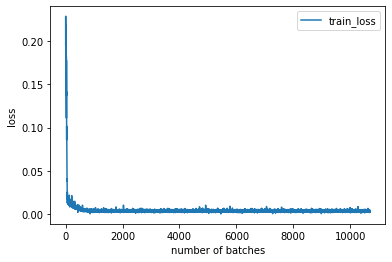

<Figure size 432x288 with 0 Axes>

In [107]:
#train_loss曲线
x = np.linspace(0,len(train_log),len(train_log))
plt.plot(x,train_log,label="train_loss",linewidth=1.5)
#plt.plot(x_test,test_log[:,0],label="test_rmse_loss",linewidth=1.5)
#plt.plot(x_test,test_log[:,1],label="test_mae_loss",linewidth=1.5)
#plt.plot(x_test,test_log[:,2],label="test_mape_loss",linewidth=1.5)
plt.xlabel("number of batches")
plt.ylabel("loss")
plt.legend()
plt.show()
plt.savefig('1.1manualRNNtrainloss.jpg')
#plt.clf()

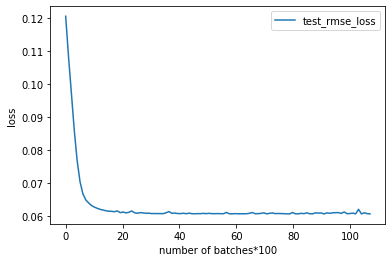

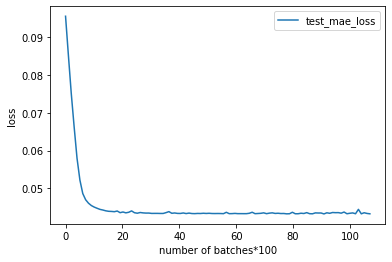

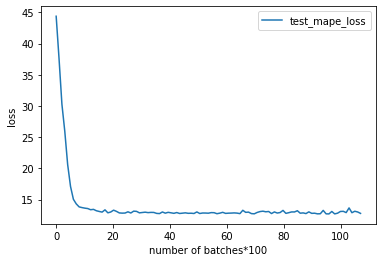

<Figure size 432x288 with 0 Axes>

In [108]:
#test_loss曲线
x_test= np.linspace(0,len(test_log),len(test_log))
test_log = np.array(test_log)
plt.plot(x_test,test_log[:,0],label="test_rmse_loss",linewidth=1.5)
plt.xlabel("number of batches*100")
plt.ylabel("loss")
plt.legend()
plt.show()
plt.savefig('1.1manualRNNtestrmseloss.jpg')
#plt.clf()

#test_loss曲线
x_test= np.linspace(0,len(test_log),len(test_log))
test_log = np.array(test_log)
plt.plot(x_test,test_log[:,1],label="test_mae_loss",linewidth=1.5)
plt.xlabel("number of batches*100")
plt.ylabel("loss")
plt.legend()
plt.show()
plt.savefig('1.1manualRNNtestrmaeloss.jpg')
#plt.clf()

#test_loss曲线
x_test= np.linspace(0,len(test_log),len(test_log))
test_log = np.array(test_log)
plt.plot(x_test,test_log[:,2],label="test_mape_loss",linewidth=1.5)
plt.xlabel("number of batches*100")
plt.ylabel("loss")
plt.legend()
plt.show()
plt.savefig('1.1manualRNNtestrmapeloss.jpg')
#plt.clf()